**Created csv with amplitude and time**

In [1]:
import pandas as pd

# Define the path to your raw BCG file
input_path = r"F:\Gam3a\Data Analytics\Final project\final_project\dataset\data\01\BCG\01_20231105_BCG.csv"
output_path = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG.csv"

# Read the CSV file, skipping the first row to get just the amplitude values
with open(input_path, 'r') as f:
    lines = f.readlines()

# Extract header and fs
header = lines[0].strip().split(',')
first_line = lines[1].strip().split(',')
fs = int(first_line[2]) if len(first_line) > 2 else 140
start_timestamp = int(first_line[1]) / 1000  # convert from ms to seconds

# Extract BCG values
bcg_values = []
for line in lines[1:]:
    parts = line.strip().split(',')
    if parts[0].lstrip('-').isdigit():
        bcg_values.append(int(parts[0]))

# Generate time vector based on fs
time_vector = [start_timestamp + i / fs for i in range(len(bcg_values))]

# Create DataFrame
df = pd.DataFrame({
    'Time (s)': time_vector,
    'BCG Amplitude': bcg_values
})

# Save to new CSV
df.to_csv(output_path, index=False)

print(f"Processed CSV saved to: {output_path}")


Processed CSV saved to: F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG.csv


**Resampling + main of doctor**

In [2]:
# Import required libraries
import math
import os

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, resample

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot

# ======================================================================================================================
# Main program starts here
print('\nStart processing ...')

# Path to input CSV (140 Hz sampled data)
input_path = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG.csv"
output_path = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG_50_Hz.csv"

# Sampling rates
original_fs = 140
target_fs = 50

# Load original CSV file
df = pd.read_csv(input_path)

# Extract data
time = df["Time (s)"].values
amplitude = df["BCG Amplitude"].values

# Duration and number of target samples
duration = time[-1] - time[0]
n_target = int(duration * target_fs)

# Resample amplitude
amplitude_resampled = resample(amplitude, n_target)

# Create new time vector
time_resampled = np.linspace(time[0], time[-1], n_target)

# Create new DataFrame and save to CSV
df_resampled = pd.DataFrame({
    "Time (s)": time_resampled,
    "BCG Amplitude": amplitude_resampled
})
df_resampled.to_csv(output_path, index=False)

print(f"\nResampled data saved to: {output_path}")

# ======================================================================================================================
# Load the resampled data for processing
rawData = df_resampled.values
utc_time = rawData[:, 0]
data_stream = rawData[:, 1]

start_point, end_point, window_shift, fs = 0, 500, 500, target_fs  # now fs = 50
# ==========================================================================================================
data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
# ==========================================================================================================
# BCG signal extraction
movement = band_pass_filtering(data_stream, fs, "bcg")
# ==========================================================================================================
# Respiratory signal extraction
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
# ==========================================================================================================
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
# ==========================================================================================================
# Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
# ==========================================================================================================
# Heart Rate
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
print('\nHeart Rate Information')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
# Breathing Rate
beats = vitals(t1, t2, window_shift, limit, breathing, utc_time, mpd=1, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(beats)))
print('Maximum breathing : ', np.around(np.max(beats)))
print('Average breathing : ', np.around(np.mean(beats)))
# ==============================================================================================================
thresh = 0.3
events = apnea_events(breathing, utc_time, thresh=thresh)
# ==============================================================================================================
# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)
# ==================================================================================================================
print('\nEnd processing ...')



Start processing ...

Resampled data saved to: F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG_50_Hz.csv

Heart Rate Information
Minimum pulse :  42253.0
Maximum pulse :  79316.0
Average pulse :  59230.0

Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  29412.0
Average breathing :  13513.0

Apnea Information
start time :  ['07.30.01']  stop time :  ['07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.3

**plot resampled data**

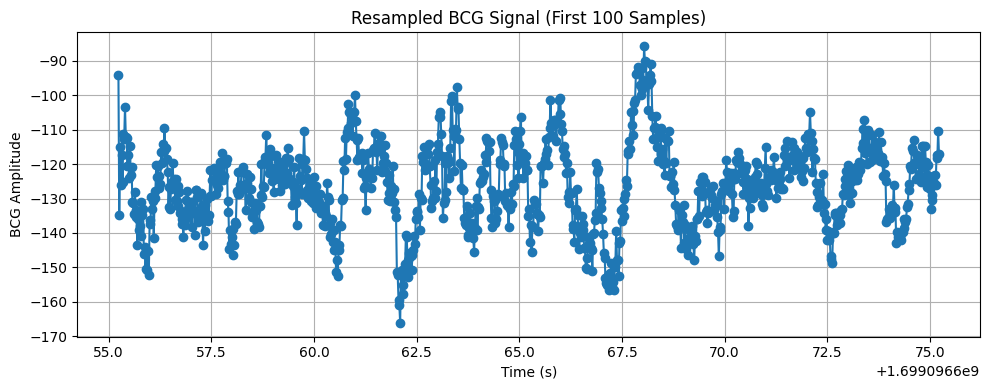

In [4]:
# Add this at the beginning of your cell to enable inline plotting
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Path to resampled CSV
resampled_csv_path = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG_50_Hz.csv"

# Load the data
df = pd.read_csv(resampled_csv_path)

# Extract the first 1000 rows
df_plot = df.head(1000)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_plot["Time (s)"], df_plot["BCG Amplitude"], marker='o', linestyle='-')
plt.title("Resampled BCG Signal (First 100 Samples)")
plt.xlabel("Time (s)")
plt.ylabel("BCG Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


**syncronization**

In [7]:
import pandas as pd

# 1) Paths: adjust to your actual files
input_csv  = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\BCG_50_Hz.csv"
output_csv = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\normal_date_BCG.csv"

# 2) Load
df = pd.read_csv(input_csv)

# 3) Convert Unix‐time to datetime strings
#    If "Time (s)" is a float, we floor or round as you prefer;
#    here we just interpret the integer part as whole seconds.
df['DateTime'] = pd.to_datetime(df['Time (s)'], unit='s') \
                   .dt.strftime('%Y/%m/%d %H:%M:%S')

# 4) (Optional) If you want to replace the original column:
#    df.drop(columns=['Time (s)'], inplace=True)
#    df.rename(columns={'DateTime':'Time (s)'}, inplace=True)

# 5) Save out
df.drop(columns=['Time (s)'], inplace=True)
df.to_csv(output_csv, index=False)
print(f"Saved converted CSV to: {output_csv}")


Saved converted CSV to: F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\normal_date_BCG.csv


In [8]:
import pandas as pd

# ── 1) Adjust these paths to point at your actual files ─────────────────────────
ecg_csv_in   = r"F:\Gam3a\Data Analytics\Final project\final_project\dataset\data\01\Reference\RR\01_20231105_RR.csv"
bcg_csv_in   = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\normal_date_BCG.csv"

ecg_csv_out  = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\ecg_synchronized.csv"
bcg_csv_out  = r"F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\bcg_synchronized.csv"

# ── 2) Load both CSVs ───────────────────────────────────────────────────────────
df_ecg = pd.read_csv(ecg_csv_in)
df_bcg = pd.read_csv(bcg_csv_in)

# ── 3) Parse their time columns to pandas datetime ─────────────────────────────
#    (adjust formats if your strings differ)
df_ecg['dt'] = pd.to_datetime(df_ecg['Timestamp'], format='%Y/%m/%d %H:%M:%S')
df_bcg['dt'] = pd.to_datetime(df_bcg['DateTime'], format='%Y/%m/%d %H:%M:%S')

# ── 4) Compute overlapping window ───────────────────────────────────────────────
start_ecg = df_ecg['dt'].min()
end_ecg   = df_ecg['dt'].max()

start_bcg = df_bcg['dt'].min()
end_bcg   = df_bcg['dt'].max()

# the sync window is from the later of the two starts to the earlier of the two ends
sync_start = max(start_ecg, start_bcg)
sync_end   = min(end_ecg,   end_bcg)

print(f"Synchronizing both signals to window:\n  start = {sync_start}\n    end = {sync_end}")

# ── 5) Trim each DataFrame to that window ────────────────────────────────────────
df_ecg_sync = df_ecg[(df_ecg['dt'] >= sync_start) & (df_ecg['dt'] <= sync_end)].copy()
df_bcg_sync = df_bcg[(df_bcg['dt'] >= sync_start) & (df_bcg['dt'] <= sync_end)].copy()

# ── 6) (Optional) drop the helper 'dt' columns or reorder as you like
#    Here we keep the original timestamp columns and drop the parsed 'dt' column:
df_ecg_sync = df_ecg_sync.drop(columns=['dt'])
df_bcg_sync = df_bcg_sync.drop(columns=['dt'])

# ── 7) Save out the synchronized CSVs ───────────────────────────────────────────
df_ecg_sync.to_csv(ecg_csv_out, index=False)
df_bcg_sync.to_csv(bcg_csv_out, index=False)

print("Saved synchronized ECG to:", ecg_csv_out)
print("Saved synchronized BCG to:", bcg_csv_out)


Synchronizing both signals to window:
  start = 2023-11-04 19:12:20
    end = 2023-11-04 22:05:51
Saved synchronized ECG to: F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\ecg_synchronized.csv
Saved synchronized BCG to: F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\bcg_synchronized.csv


In [9]:
import pandas as pd

# Load the CSV
bcg_sync = pd.read_csv(r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\bcg_synchronized.csv')

# Convert 'DateTime' to datetime and then to Unix timestamp
bcg_sync['DateTime'] = pd.to_datetime(bcg_sync['DateTime'])
bcg_sync['UnixTime'] = bcg_sync['DateTime'].apply(lambda x: int(x.timestamp()))

# Drop the DateTime column
bcg_sync.drop(columns=['DateTime'], inplace=True)

# Save updated CSV
bcg_sync.to_csv(
    r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\unix_bcg_synchronized.csv',
    index=False
)

print("DateTime column dropped and file saved.")


DateTime column dropped and file saved.


**main code from doctor**

In [11]:
# Import required libraries
import math
import os

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
# ======================================================================================================================

# Main program starts here
print('\nstart processing ...')

file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\unix_01_20231105_BCG_time_sync.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        print(utc_time)
        data_stream = rawData[:, 0]
        print(data_stream)

        start_point, end_point, window_shift, fs = 0, 500, 500, 50
        # ==========================================================================================================
        data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
        print('Data stream:', data_stream)
        print('UTC time:', utc_time)
        # ==========================================================================================================
        # BCG signal extraction
        movement = band_pass_filtering(data_stream, fs, "bcg")
        # ==========================================================================================================
        # Respiratory signal extraction
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        # ==========================================================================================================
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]
        # ==========================================================================================================
        # Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
        t1, t2, window_length, window_shift = 0, 500, 500, 500
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(breathing.size / window_shift))
        # ==========================================================================================================
        # Heart Rate
        beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
        print('\nHeart Rate Information')
        print('Minimum pulse : ', np.around(np.min(beats)))
        print('Maximum pulse : ', np.around(np.max(beats)))
        print('Average pulse : ', np.around(np.mean(beats)))
        # Breathing Rate
        beats = vitals(t1, t2, window_shift, limit, breathing, utc_time, mpd=1, plot=0)
        print('\nRespiratory Rate Information')
        print('Minimum breathing : ', np.around(np.min(beats)))
        print('Maximum breathing : ', np.around(np.max(beats)))
        print('Average breathing : ', np.around(np.mean(beats)))
        # ==============================================================================================================
        thresh = 0.3
        events = apnea_events(breathing, utc_time, thresh=thresh)
        # ==============================================================================================================
        # Plot Vitals Example
        t1, t2 = 2500, 2500 * 2
        data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)
        # ==============================================================================================================
    print('\nEnd processing ...')
    # ==================================================================================================================


start processing ...
[1.69912514e+09 1.69912514e+09 1.69912514e+09 ... 1.69913555e+09
 1.69913555e+09 1.69913555e+09]
[ -43.44227434  -32.7365673  -284.24400645 ...  -29.22937811  -34.29356231
  -25.71231843]
Data stream: [ -32.7365673  -284.24400645 -843.99575211 ...  -29.22937811  -34.29356231
  -25.71231843]
UTC time: [1.69912514e+09 1.69912514e+09 1.69912514e+09 ... 1.69913555e+09
 1.69913555e+09 1.69913555e+09]

Heart Rate Information
Minimum pulse :  60000.0
Maximum pulse :  102000.0
Average pulse :  81488.0

Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  30000.0
Average breathing :  16966.0

Apnea Information
start time :  ['23.28.45']  stop time :  ['23.28.45']

Apnea Information
start time :  ['23.28.45', '23.28.46']  stop time :  ['23.28.45', '23.28.46']

Apnea Information
start time :  ['23.28.45', '23.28.46', '23.28.46']  stop time :  ['23.28.45', '23.28.46', '23.28.46']

Apnea Information
start time :  ['23.28.45', '23.28.46', '23.28.46', '23.2

**partitionin main for debugging**

In [34]:
# Add this at the beginning of your cell to enable inline plotting
%matplotlib inline

import math
import os

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ======================================================================================================================

# Main program starts here
print('\nstart processing ...')

file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\unix_bcg_synchronized.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        print(utc_time)
        data_stream = rawData[:, 0]
        print(data_stream)

        start_point, end_point, window_shift, fs = 0, 500, 500, 50
        # ==========================================================================================================
        data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
        print('Data stream:', data_stream)
        print('UTC time:', utc_time)

# Additional code for displaying 3 consecutive windows
window_size = 500  # Size of each window in the plot
num_windows_to_plot = 5  # Plot 3 consecutive windows

# Set the window shift
window_shift = 500

# Show 3 consecutive windows
for i in range(num_windows_to_plot):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size
    
    # Display the window
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(start_idx, end_idx), data_stream[start_idx:end_idx], '-k', linewidth=1)
    plt.title(f"Window {i+1}: From Sample {start_idx} to {end_idx}")
    plt.xlabel('Time [Samples]')
    plt.ylabel('Amplitude [mV]')
    plt.gca().set_xticklabels(np.arange(start_idx, end_idx, 100), rotation=45)
    
    plt.grid(True)
    plt.show()



start processing ...


KeyboardInterrupt: 

**new detect_patterns**

In [19]:
import math
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def detect_patterns1(pt1, pt2, win_size, data, time, plot=0):
    # Store start and end point
    pt1_, pt2_ = pt1, pt2

    limit = int(math.floor(data.size / win_size))
    flag = np.zeros([data.size, 1])
    event_flags = np.zeros([limit, 1])
    segments_sd = []

    # Compute standard deviation for each window
    for i in range(limit):
        sub_data = data[pt1:pt2]
        segments_sd.append(np.std(sub_data, ddof=1))
        pt1 = pt2
        pt2 += win_size

    # Compute MAD
    mad = np.sum(np.abs(segments_sd - np.mean(segments_sd))) / len(segments_sd)
    thresh1, thresh2 = 15, 2 * mad

    # Reset pt1 and pt2
    pt1, pt2 = pt1_, pt2_

    # Classify each window
    for j in range(limit):
        std_fos = np.around(segments_sd[j])
        if std_fos < thresh1:
            flag[pt1:pt2] = 3  # No movement
            event_flags[j] = 3
        elif std_fos > thresh2:
            flag[pt1:pt2] = 2  # Movement
            event_flags[j] = 2
        else:
            flag[pt1:pt2] = 1  # Sleeping
            event_flags[j] = 1
        pt1 = pt2
        pt2 += win_size

    # Plotting
    if plot == 1:
        data_for_plot = data
        width = np.min(data_for_plot)
        height = np.max(data_for_plot) + abs(width) if width < 0 else np.max(data_for_plot)

        current_axis = plt.gca()
        plt.plot(np.arange(data.size), data_for_plot, '-k', linewidth=1)
        plt.xlabel('Time [Samples]')
        plt.ylabel('Amplitude [mV]')
        plt.gcf().autofmt_xdate()

        for j in range(limit):
            start_idx = j * win_size
            end_idx = start_idx + win_size
            sub_data = data_for_plot[start_idx:end_idx]
            sub_time = np.arange(start_idx, end_idx) / 50.0

            if event_flags[j] == 3:  # No-movement
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#FAF0BE", alpha=.2))
            elif event_flags[j] == 2:  # Movement
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#FF004F", alpha=1.0))
            else:  # Sleeping
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#00FFFF", alpha=.2))

        plt.savefig('./results/rawData.png')

    # Identify indices to remove (movement and no-movement)
    bad_indices = []
    for j in range(limit):
        start_idx = j * win_size
        end_idx = start_idx + win_size
        if event_flags[j] == 2 or event_flags[j] == 3:
            bad_indices.extend(range(start_idx, end_idx))

    bad_indices = np.array(bad_indices)
    valid_indices = bad_indices[(bad_indices >= 0) & (bad_indices < len(time))]  # Ensure safe indexing

    removed_timestamps_unix = time[valid_indices]

    # Mask out the bad indices
    mask = np.ones(len(data), dtype=bool)
    mask[valid_indices] = False
    filtered_data = data[mask]
    filtered_time = time[mask]

    return filtered_data, filtered_time, removed_timestamps_unix


In [ ]:
# Import required libraries
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
# from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
# ======================================================================================================================

# Main program starts here
print('\nstart processing ...')

# File path
file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\unix_bcg_synchronized.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    
    # Check if the file is not empty
    if os.stat(fileName).st_size != 0:
        
        # Read the data from the file
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]

        # Define parameters for windowing
        start_point, end_point, window_shift, fs = 0, 500, 500, 50

        # ==========================================================================================================
        # Apply the detect_patterns function
        data_stream_filtered, utc_time_filtered, removed = detect_patterns1(
            start_point, end_point, window_shift, data_stream, utc_time, plot=0
        )

        # Create a DataFrame to save the filtered results
        filtered_data = pd.DataFrame({
            'UTC_Time': utc_time_filtered,
            'Data_Stream': data_stream_filtered
        })

        # Save the filtered data to a new CSV file
        output_file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\500_samples_bcg.csv'
        filtered_data.to_csv(output_file, index=False)

        np.set_printoptions(threshold=np.inf)
        print('filtered times', removed)


In [50]:
import pandas as pd

# Load the CSV file
file_path = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\unix_bcg_synchronized.csv'
df = pd.read_csv(file_path)

# Round the first column to 1 decimal place
df['BCG Amplitude'] = df['BCG Amplitude'].round(1)

# Save with float format to enforce 1 decimal place in output
output_file_path = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\rounded_unix_bcg_synchronized.csv'
df.to_csv(output_file_path, index=False, header=False, float_format='%.1f')


In [66]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\rounded_unix_bcg_synchronized.csv'

rawData = pd.read_csv(file, sep=",", header=None).values
utc_time = rawData[:, 1]
data_stream = rawData[:, 0]
print(data_stream)

KeyboardInterrupt: 

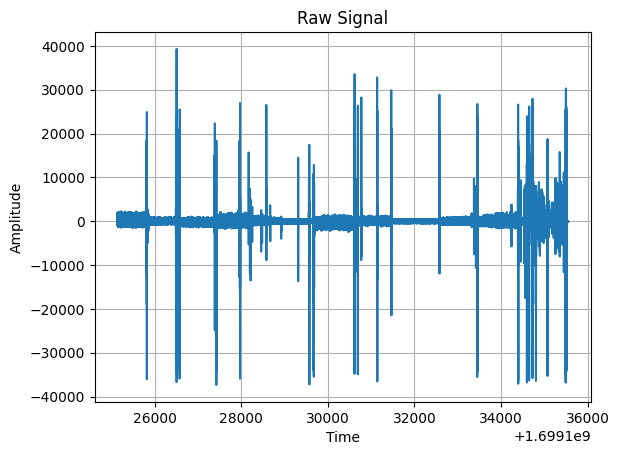

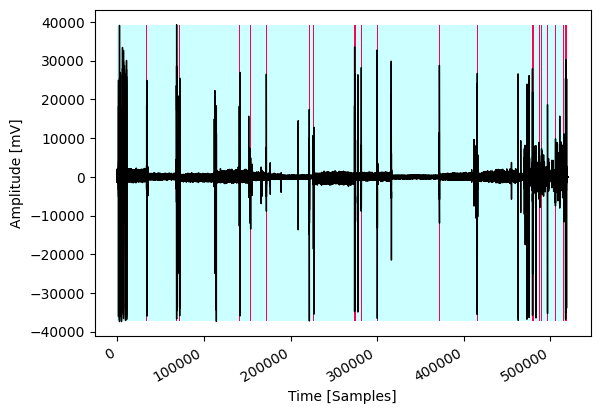

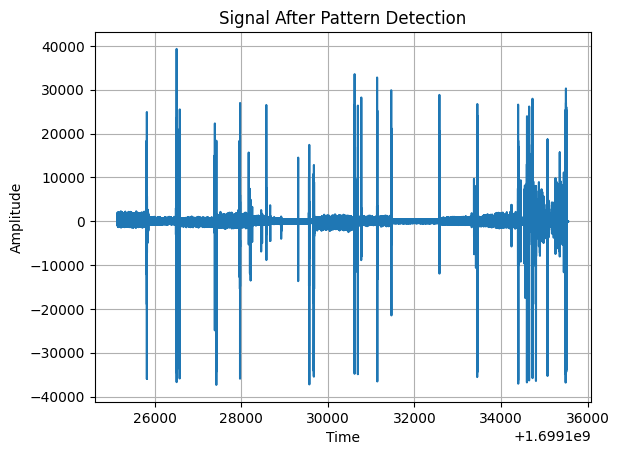

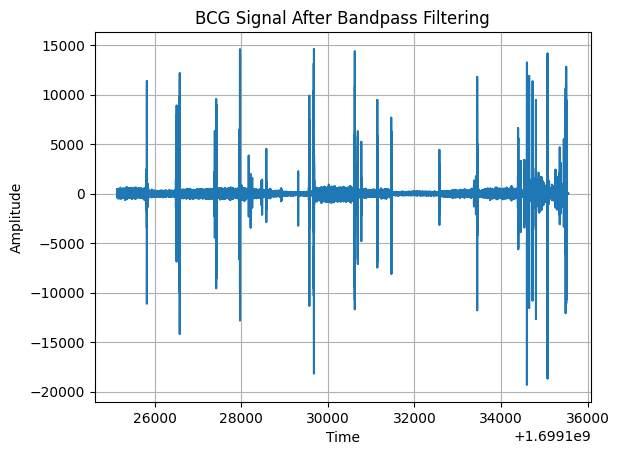

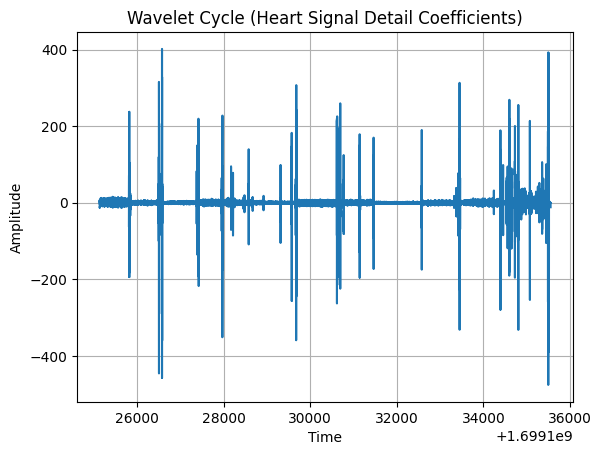


Heart Rate Information
Minimum pulse :  60000.0
Maximum pulse :  102000.0
Average pulse :  81337.0


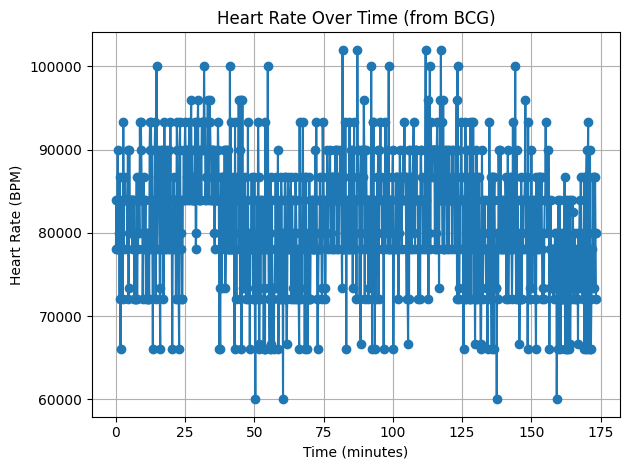


Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  30000.0
Average breathing :  16974.0

Apnea Information
start time :  ['07.30.01']  stop time :  ['07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.

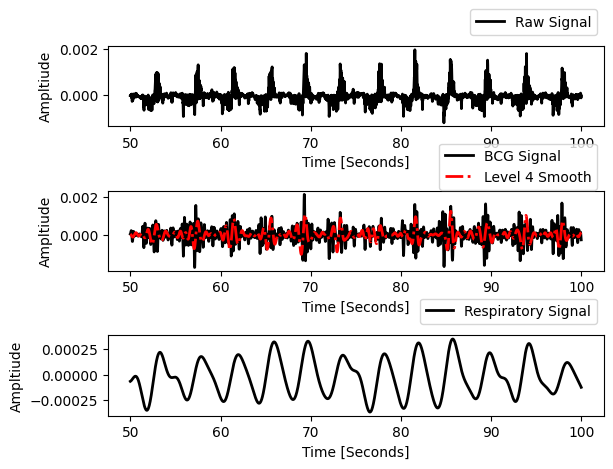

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\rounded_unix_bcg_synchronized.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]
        # Plot raw signal
        plt.figure()
        plt.plot(utc_time, data_stream)
        plt.title("Raw Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        start_point, end_point, window_shift, fs = 0, 500, 500, 50

        # ==========================================================================================================
        data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)

        # Plot after pattern detection
        plt.figure()
        plt.plot(utc_time, data_stream)
        plt.title("Signal After Pattern Detection")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # BCG signal extraction
        movement = band_pass_filtering(data_stream, fs, "bcg")

        # Plot BCG signal
        plt.figure()
        plt.plot(utc_time, movement)
        plt.title("BCG Signal After Bandpass Filtering")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # Respiratory signal extraction
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        # ==========================================================================================================
        # Wavelet transform
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]

        # Plot wavelet cycle (heart activity)
        plt.figure()
        plt.plot(utc_time, wavelet_cycle)
        plt.title("Wavelet Cycle (Heart Signal Detail Coefficients)")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
        t1, t2, window_length, window_shift = 0, 500, 500, 500
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(breathing.size / window_shift))

        # Heart Rate
        beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
        print('\nHeart Rate Information')
        print('Minimum pulse : ', np.around(np.min(beats)))
        print('Maximum pulse : ', np.around(np.max(beats)))
        print('Average pulse : ', np.around(np.mean(beats)))

        # Plot heart rate over windows
        plt.figure()
        time_axis = np.arange(len(beats)) * (window_shift / fs) / 60  # in minutes
        plt.plot(time_axis, beats, marker='o', linestyle='-')
        plt.title('Heart Rate Over Time (from BCG)')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Heart Rate (BPM)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ==========================================================================================================
        # Breathing Rate (optional)
        beats = vitals(t1, t2, window_shift, limit, breathing, utc_time, mpd=1, plot=0)
        print('\nRespiratory Rate Information')
        print('Minimum breathing : ', np.around(np.min(beats)))
        print('Maximum breathing : ', np.around(np.max(beats)))
        print('Average breathing : ', np.around(np.mean(beats)))

        # ==========================================================================================================
        # Apnea Detection
        thresh = 0.3
        events = apnea_events(breathing, utc_time, thresh=thresh)

        # ==========================================================================================================
        # Plot Combined Vitals Example
        t1, t2 = 2500, 2500 * 2
        data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)

        print('\nEnd processing ...')



start processing ...


f:\Gam3a\Data Analytics\Final project\final_project\code\beat_to_beat.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  bpm_avg = 1000 * (60 / mean_heart_rate)



Heart Rate Information
Minimum pulse :  0.0
Maximum pulse :  inf
Average pulse :  inf


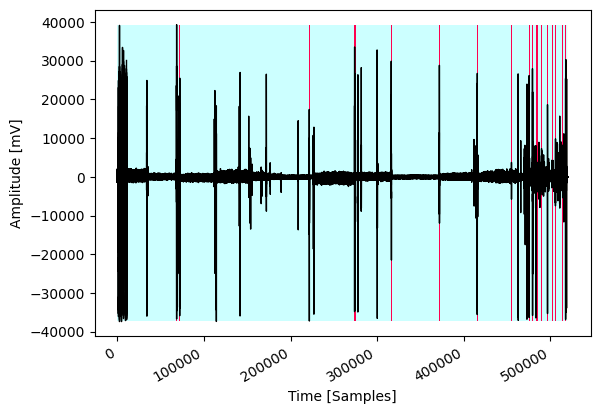

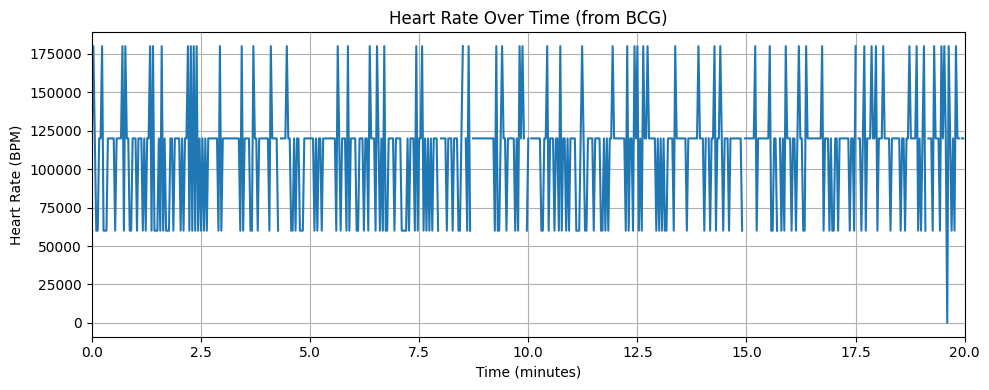


End processing ...


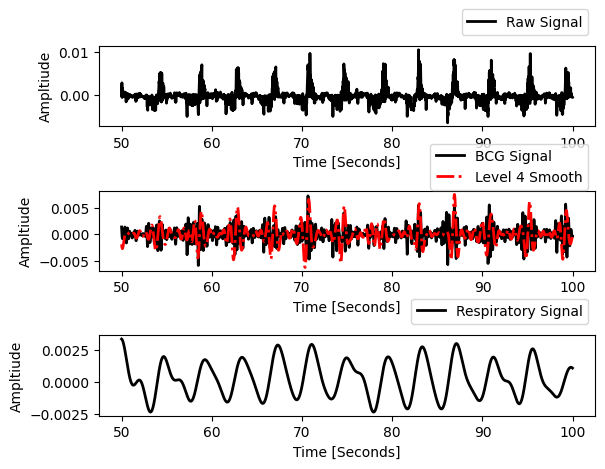

In [31]:
# Import required libraries
%matplotlib inline

import math
import os

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
import matplotlib.pyplot as plt
# ======================================================================================================================

# Main program starts here
print('\nstart processing ...')

file = r'F:\Gam3a\Data Analytics\Final project\final_project\code\trial_output\unix_bcg_synchronized.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]

        start_point, end_point, window_shift, fs = 0, 100, 100, 50
        # ==========================================================================================================
        data_stream, utc_time, removed = detect_patterns1(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
        # ==========================================================================================================
        # BCG signal extraction
        movement = band_pass_filtering(data_stream, fs, "bcg")
        # ==========================================================================================================
        # Respiratory signal extraction
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        # ==========================================================================================================
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]
        # ==========================================================================================================
        # Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
        t1, t2, window_length, window_shift = 0, 100, 100, 100
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(breathing.size / window_shift))
        # ==========================================================================================================
        # Heart Rate
        beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
        print('\nHeart Rate Information')
        print('Minimum pulse : ', np.around(np.min(beats)))
        print('Maximum pulse : ', np.around(np.max(beats)))
        print('Average pulse : ', np.around(np.mean(beats)))
        plt.figure(figsize=(10, 4))
        time_axis = np.arange(len(beats)) * (window_shift / fs) / 60  # Convert to minutes if desired
        plt.plot(time_axis, beats, linestyle='-')
        plt.title('Heart Rate Over Time (from BCG)')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Heart Rate (BPM)')
        plt.xlim(0, 20)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
               # Plot Vitals Example
        t1, t2 = 2500, 2500 * 2
        data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)
    print('\nEnd processing ...')
    # ==================================================================================================================